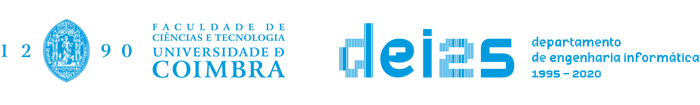



# Classifica√ß√£o de dados Eletromiogr√°ficos (EMG)

Neste notebook vamos analizar sinais EMG de duas tarefas compostas por 12 ciclos de relaxamento e a√ß√£o cada. A primeira tarefa consiste em apertar a m√£o (SQUEEZE) e a segunda em flexionar o bra√ßo (FLEX). Cada a√ß√£o tem a dura√ß√£o de 5 segundos e √© antecedida por outros 5 segundos em estado de repouso (RELAX).

O objetivo passa por extra√≠r caracter√≠sticas (features) de cada segmento de sinal EMG que permitam facilitar a identifica√ß√£o autom√°tica da classe de movimento correspondente (RELAX, SQUEEZE ou FLEX). Cada Movimento vai ser mapeado para uma class da seguinte forma:


*   RELAX - 0
*   SQUEEZE - 1
*   FLEX - 2




# Carregar os dados

O primeiro passo passa por carregar os dados dos ficheiros para que os possamos manipular.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

path_to_data = 'https://raw.githubusercontent.com/nunolourenco/talentos-2024/main/DadosParaClassificar.csv'

dados = pd.read_csv(path_to_data)



# Que dados?
Nesta sess√£o vamos utilizar as features que voc√™s j√° obtiveram na sess√£o anterior. 

Como se devem recordar, foi poss√≠vel concluir que a **Amplitude M√©dia** e o **Decl√≠ve da Amplitude** combinados apresentam visualmente uma separabilidade elevada, o que facilitar√° a indentifica√ß√£o correta da classe correspondente por parte de um classificador.

Vamos come√ßar por ver os dados na sua forma de tabela. A tabela tem 3 colunas:


*   AmplitudeMedia
*   DecliveAmplitude
*   TipoMovimento - Esta coluna indica qual o tipo de movimento de cada inst√¢ncia.

O **TipoMovimento** tem os seguintes valores:


0. RELAX
1. SQUEZE
2. FLEX




Cada linha corresponde a um tipo de movimento, que vai ser caracterizado pela **Amplitude M√©dia** e pelo **Decl√≠ve da Amplitude**. Usando o tipo de movimento, eu posso criar ("ensinar") um modelo a distinguir os diferentes movimentos.



In [4]:
dados

AmplitudeMedia  DecliveAmplitude  TipoMovimento
0         0.370792          0.034037              0
1         0.351560          0.016049              0
2         0.385709         -0.019236              0
3         0.387414          0.037512              0
4         0.439816          0.027422              0
5         0.404428          0.017913              0
6         0.442559         -0.020638              0
7         0.386478         -0.003469              0
8         0.399242         -0.044242              0
9         0.398945          0.021433              0
10        0.393350         -0.001641              0
11        0.416631         -0.039228              0
12        0.487754         -0.052070              0
13        0.481843         -0.192090              0
14        0.425295         -0.129085              0
15        0.427277         -0.185983              0
16        0.402128         -0.142020              0
17        0.430864         -0.108000              0
18        0.509348         -0.119779              0
19        0.433091         -0.156247              0
20        0.421193         -0.123424              0
21        0.399947         -0.177758              0
22        0.387912         -0.169842              0
23        0.407129         -0.139689              0
24        0.536414         -0.093037              1
25        0.836829         -0.035463              1
26        0.889692         -0.122075              1
27        1.335013         -0.452792              1
28        1.011042         -0.203961              1
29        1.044494         -0.015066              1
30        1.039288         -0.178814              1
31        1.105502         -0.067927              1
32        1.032997         -0.022461              1
33        1.055255         -0.141828              1
34        1.017972         -0.202012              1
35        0.995734          0.121304              1
36        0.929394         -0.144234              2
37        0.940957         -0.304897              2
38        0.878854         -0.205065              2
39        0.905468         -0.306655              2
40        0.819823         -0.304313              2
41        0.837154         -0.332207              2
42        0.839801         -0.329948              2
43        0.899787         -0.440289              2
44        0.960838         -0.360132              2
45        0.956772         -0.371718              2
46        0.892296         -0.365063              2
47        0.896279         -0.321322              2

# Relembrando

Na aula anterior, utilizaram um scatter plot para visualizar o cruzamento entre as duas features. Verificaram que apesar de nenhuma das features individualmente n√£o conseguir separar claramente as 3 classes, combinando as duas conseguem ter uma boa separabilidade no plano.


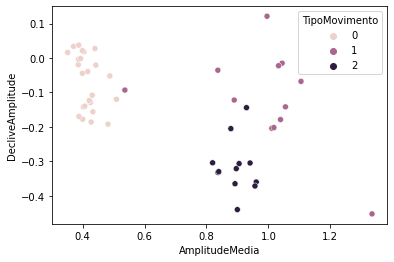

In [20]:
sns.scatterplot(data=dados, x="AmplitudeMedia", y="DecliveAmplitude", hue="TipoMovimento")


# Classifica√ß√£o Bin√°ria

Na parte te√≥rica, n√≥s vimos como construir um modelo linear para distinguir entre duas classes. 

*No entanto, o nosso problema tem 3 classes!!!!*

Como resolver isto?! Bem, vamos transformar o problema numa situa√ß√£o em que quero identificar se o m√∫sculo est√°:

0. RELAX
1. NOT RELAXED


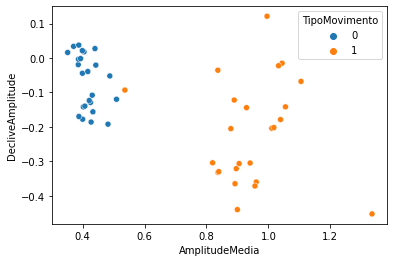

In [21]:
dados_classificacao_binaria = dados.copy()
dados_classificacao_binaria = dados_classificacao_binaria.replace(to_replace=2, value=1)
dados_classificacao_binaria
sns.scatterplot(data=dados_classificacao_binaria, x="AmplitudeMedia", y="DecliveAmplitude", hue="TipoMovimento")


# Criar um modelo de Classifica√ß√£o

# Passo 1 - Dividir em Treino e Teste
Primeira coisa que temos de fazer √© dividir o nosso dataset em 2

*   Treino - Vai ser utilizado para encontrar os par√¢metros, i.e., o m<sub>1</sub> o m<sub>2</sub> e o b do nosso modelo.
*   Teste - Vai ser utilizado para medir a capacidade que o nosso modelo tem para trabalhar em dados que nunca viu! N√≥s queremos que o nosso modelo seja capaz de distinguir situa√ß√µes que nunca viu de RELAX e de NOT RELAX



In [22]:
# Vamos dividir o dataset em treino e teste
features_binario = dados_classificacao_binaria[['AmplitudeMedia','DecliveAmplitude']]
movimentos_binario = dados_classificacao_binaria['TipoMovimento']
# A fun√ß√£o train_test_split faz a divis√£o em treino e teste. Neste caso vamos usar 70% dos dados para treino (train_size=0.7) e 30% para teste (test_size=0.3)
Features_binario_treino, Features_binario_teste, movimentos_binario_treino, movimentos_binario_teste = train_test_split(features_binario, movimentos_binario, train_size = 0.7, test_size = 0.3, random_state = 100)

# Passo 2 - Criar e treinar um modelo bin√°rio

Em seguinda temos de treinar o nosso modelo. Para isso, vamos utilizar a biblioteca [scikit-learn](https://scikit-learn.org/stable/), nomeadamente o modelo de [Regress√£o Logistica](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Para treinar o modelo, isto √©, para encontrar os par√¢metros, i.e., o m<sub>1</sub> o m<sub>2</sub> e o b, vamos utilizar o m√©todo *fit* com os nossos dados de treino.




In [23]:
# Cria um modelo geral de Regress√£o Logistica
regressao_logistica_binaria = LogisticRegression()
# O m√©todo fit vai procurar quais os parametros m1, m2 e b que nos permitem dividir com menor erro as duas classes
regressao_logistica_binaria.fit(Features_binario_treino, movimentos_binario_treino)

LogisticRegression()

Depois de treinar o modelo podemos consultar os coeficientes associados a cada uma das v√°ri√°veis, bem como o nosso b, isto √©, a ordenada na origem. 

Vamos come√ßar por consultar os coeficientes:

In [24]:
regressao_logistica_binaria.coef_

array([[ 2.61985362, -0.60694919]])

E agora o b:

In [25]:
regressao_logistica_binaria.intercept_

array([-1.99594446])

Assim, n√≥s sabemos que o nosso modelo corresponde √© o seguinte:

$Classe = \begin{cases}
			0, & \text{Se $œÉ(Y) < 0.5$ }\\
            1, & \text{Se $œÉ(Y) \geq 0.5$ }
		 \end{cases}
$

onde

$ Y = -1.9959 + 2.6198 * AmplitudeMedia - 0.6069 * DecliveAmplitude $

e 

$œÉ(Y) = \frac{1}{1 + e^{-Y}}$

# Passo 4 - Visualizar a Fronteira de Decis√£o

Depois de treinar o modelo e de obtermos os coeficientes associados a cada vari√°vel podemos visualizar a fronteira de decis√£o, isto √©, podemos fazer um gr√°fico em que colocamos a linha que vai separar a situa√ß√£o de RELAX de NOT RELAX. 

Reparem que neste caso vou apenas estar a projectar um gr√°fico em que no eixo dos xx vou ter a AmplitudeMedia, e nos eixos do yy vou ter o DecliveAmplitude.


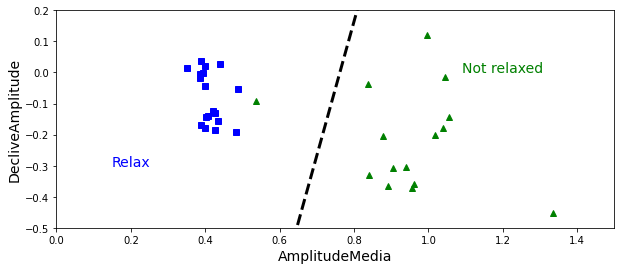

In [26]:
x0, x1 = np.meshgrid(
        np.linspace(0, 1.5, 200).reshape(-1, 1),
        np.linspace(-0.5, 0.22, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
plt.figure(figsize=(10, 4))
plt.plot(Features_binario_treino[movimentos_binario_treino==0]['AmplitudeMedia'], Features_binario_treino[movimentos_binario_treino==0]['DecliveAmplitude'], "bs")
plt.plot(Features_binario_treino[movimentos_binario_treino==1]['AmplitudeMedia'], Features_binario_treino[movimentos_binario_treino==1]['DecliveAmplitude'], "g^")
left_right = np.array([0, 1])
boundary = -(regressao_logistica_binaria.coef_[0][0] * left_right + regressao_logistica_binaria.intercept_[0]) / regressao_logistica_binaria.coef_[0][1]
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(0.2, -0.3, "Relax", fontsize=14, color="b", ha="center")
plt.text(1.2, 0.0, "Not relaxed", fontsize=14, color="g", ha="center")
plt.xlabel("AmplitudeMedia", fontsize=14)
plt.ylabel("DecliveAmplitude", fontsize=14)
plt.axis([0, 1.5, -.5, 0.2])
plt.show()

# Passo 5 - Analisar a performance do modelo no Treino

O pr√≥ximo passo corresponde a tentar perceber qual √© a performance que o nosso modelo obteve nos dados de treino. Idealmente ele deveria ser capaz de fazer uma separa√ß√£o perfeita das duas classes. No entanto isto nem sempre √© poss√≠vel, o que faz com seja importante perceber qual √© que a performance real do nosso modelo. 

Uma ferramenta muito √∫til para fazer esta an√°lise √© a matriz de confus√£o. 


Confusos?

N√£o se preocupem, n√£o precisam de estar. Na pr√°tica a matriz de confus√£o n√£o e nada mais nada menos do que uma tabela, em que nas linhas. Assim, se durante o treino o modelo classificar um inst√¢ncia RELAX (Classe 0), como pertencente √† Classe 0, significa que ele acertou, e temos um Verdadeiro Positivo. No entanto, se o modelo classificar a mesma inst√¢ncia como NOT RELAX (Classe 1) vamos ter uma Falso Negativo. 

|             |   | Previs√£o            |                     |
|-------------|---|---------------------|---------------------|
|             |   | 0                   | 1                   |
|  Observa√ß√£o | 0 | Verdadeiro Positivo | Falso Negativo      |
|             | 1 | Falso Positivo      | Verdadeiro Negativo |



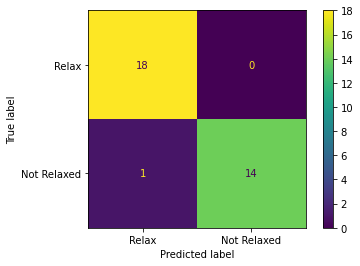

In [27]:
previsoes = regressao_logistica_binaria.predict(Features_binario_treino)
cm = confusion_matrix(movimentos_binario_treino, previsoes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Relax', 'Not Relaxed'])
disp.plot()

Olhando para os resultados da matriz de confus√£o, podemos ver que o nosso modelo √© capaz de identificar correctamente quase todos os tipos de movimento. H√° apenas 1 em que a classifica√ß√£o falha!! Mas n√≥s j√° sabiamos disto üòÄ (ver Passo 4)

# Passo 6 - Analisar a performance do modelo no Teste

N√≥s vimos que o nosso modelo tem uma performance interessante durante o treino, i.e., nos dados que sabe qual √© a sua classifica√ß√£o e para os quais ajustou os pesos.

O que n√≥s queremos √© ter um modelo que receba novos movimentos, **que nunca viu**, e que seja de identificar correctamente o tipo de movimento! Para isso temos aquilo a que chamamos dados de teste!

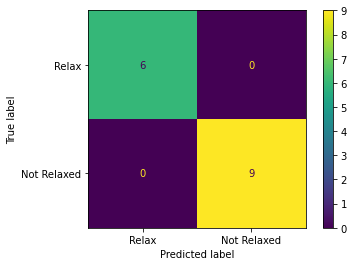

In [28]:
# Notem que mudei as features e os movimentos
previsoes = regressao_logistica_binaria.predict(Features_binario_teste)
cm = confusion_matrix(movimentos_binario_teste, previsoes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Relax', 'Not Relaxed'])
disp.plot()

Como podem oberservar o nosso modelo consegue classificar correctamente todos os exemplos que est√£o nos dados de teste. 

**Notem:** O modelo NUNCA VIU estes exemplos! Podemos dizer que ele conseguiu aprender o que distingue um movimento Relax de um Not Relax.

# Mas o que fazer quando o problema n√£o √© bin√°rio? 

No caso da Regress√£o Logistica, o que vamos ter de fazer √© separar o nosso conjunto de dados que tem m√∫ltiplas classes (3) de forma a ter v√°rios problemas de classifica√ß√£o bin√°ria. Depois, treinamos um modelo em cada problema de classifica√ß√£o bin√°ria, e o resultado √© obtido com base no que tiver maior confian√ßa.

Consideremos o nosso exemplo do EMG. O nosso modelo o que nos diz √© se o m√∫sculo est√° relaxado ou n√£o. Quando o modelo diz que ele est√° relaxado, ent√£o eu n√£o preciso de fazer mais nada. No entanto, se ele disser que aquele exemplo corresponde a uma situa√ß√£o de n√£o relaxamento, eu vou ter de descobrir se √© um SQUEEZE ou um FLEX. 

Assim, eu vou ter de dividir o meu problema original em 3 problemas de classifica√ß√£o bin√°ria:



1.   RELAX vs [SQUEEZE, FLEX]
2.   SQUEEZE vs [RELAX, FLEX]
3.   FLEX vs [RELAX, SQUEEZE]

Este tipo de estrat√©gia tem o nome de Um contra o Resto (*One-vs-rest* ou OvR)

A vantagem de utilizarmos uma biblioteca como o [scikit-learn](https://scikit-learn.org/stable/), √© que ele consegue fazer isto de forma autom√°tica. N√≥s s√≥ temos de passar o dataset com o n√∫mero de classes que queremos.


In [29]:
features = dados[['AmplitudeMedia','DecliveAmplitude']]
movimentos = dados['TipoMovimento']
Features_treino, Features_teste, movimentos_treino, movimentos_teste = train_test_split(features, movimentos, train_size = 0.7, test_size = 0.3, random_state = 100)
regressao_logistica_multi = LogisticRegression()
regressao_logistica_multi.fit(Features_treino, movimentos_treino)

LogisticRegression()

De forma an√°loga ao que fizemos para o modelo bin√°rio, podemos consultar os coeficientes, bem como o b.

Os coeficientes s√£o:

In [30]:
regressao_logistica_multi.coef_

array([[-2.22268552,  0.50642449],
       [ 1.38630629,  0.39315503],
       [ 0.83637923, -0.89957953]])

E os b's s√£o:

In [31]:
regressao_logistica_multi.intercept_

array([ 2.12212032, -1.09583333, -1.02628699])

Como podem observar, neste caso tanto para os coeficientes como para o b temos 3 valores que correspondem aos 3 modelos que foram criados.

# Performance do modelo com classes m√∫ltiplas no treino

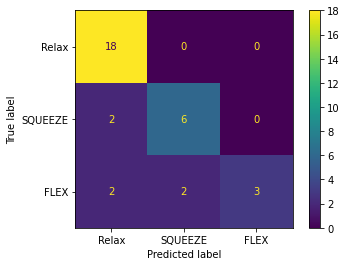

In [32]:
previsoes = regressao_logistica_multi.predict(Features_treino)
cm = confusion_matrix(movimentos_treino, previsoes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Relax', 'SQUEEZE', 'FLEX'])
disp.plot()

# Performance do modelo com classes m√∫ltiplas no teste

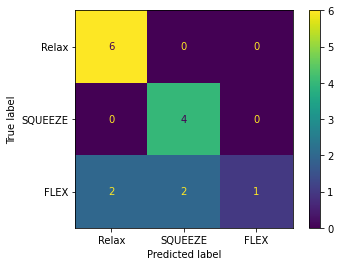

In [33]:
# Notem que mudei as features e os movimentos
previsoes = regressao_logistica_multi.predict(Features_teste)
cm = confusion_matrix(movimentos_teste, previsoes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Relax', 'SQUEEZE', 'FLEX'])
disp.plot()

N√≥s j√° sabiamos que existia alguma dificuldade em distinguir entre os SQUEEZE e os FLEX, e o nosso modelo continua com essa dificuldade.